# Map 1 - Planar layers

This is the simplest map of our collection, it is from Bennison et al. (2011).

First, we import the required libraries:

In [1]:
# Import libraries
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import geopandas as gpd
import rasterio
import gempy as gp
import gemgis as gg
from pyvistaqt import BackgroundPlotter

Then, we display the map image:

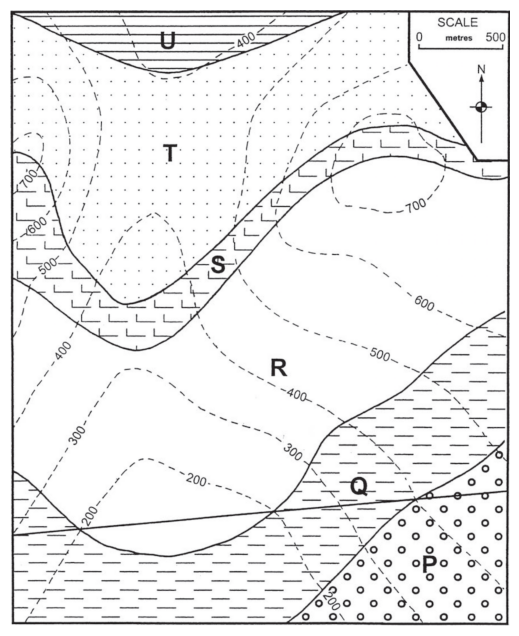

In [2]:
# Display map image
img = mpimg.imread("map1.png")
fig, ax = plt.subplots(1, figsize=(8,8))
ax.imshow(img)
ax.axis("off");

We need to construct the input data from the map. These data consist of the topography and the bedding surfaces and their orientations.

## 1. Topography

First, we need to digitize the topography. For this, we created different datasets, one for each contour line (200, 300, 400, etc.), and export them into different text files (c200.txt, c300.txt, etc.). We merged these contours lines into one text tab delimited file, contours.txt. We read this file into a pandas DataFrame, and then convert it to a geopandas DataFrame. This process is encapsulated in the following function: 

In [3]:
def df_to_gdf(path, sep):
    """
    Make pandas DataFrame from path to text file
    and convert it to and return geopandas DataFrame
    sep is the separator of the columns in the text file
    """
    df = pd.read_csv(path, sep=sep)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y), crs="EPSG:4326") # use WGS84 projection
    return gdf

We use this function throughout the notebook, whenever we need to read data from a text file and convert it to a geopandas DataFrame.

### Read and plot the contours

In [4]:
# Read the contours.txt file from the contours directory and show its first five lines
topo = df_to_gdf(os.path.join("contours", "contours.txt"), sep="\t")
topo.head()

,X,Y,Z,geometry
0,80.55,26.55,200,POINT (80.54600 26.55000)
1,124.39,84.90,200,POINT (124.38500 84.90100)
2,165.98,154.93,200,POINT (165.98300 154.92600)
3,204.46,219.66,200,POINT (204.46400 219.66300)
4,241.11,288.68,200,POINT (241.11400 288.68200)


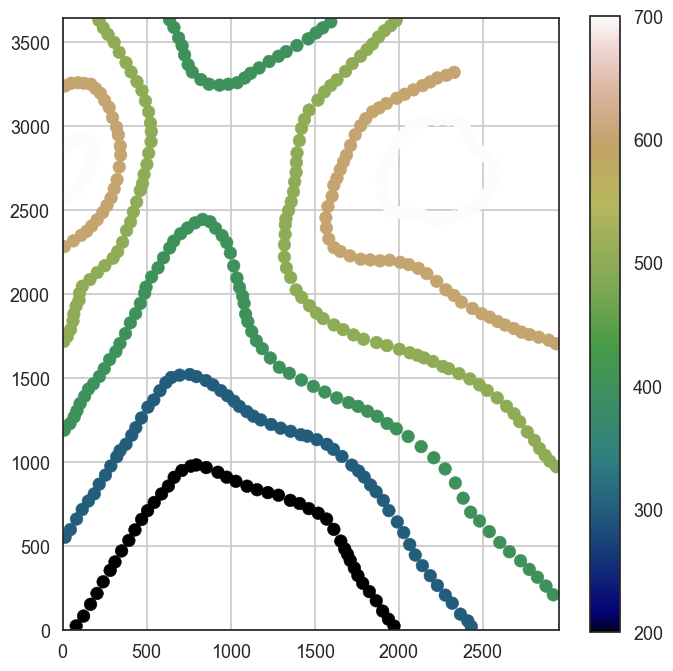

In [5]:
# Plot the contours
fig, ax = plt.subplots(1, figsize=(8, 8))
topo.plot(ax=ax, aspect="equal",column="Z", cmap="gist_earth", legend=True)
ax.set_ylim((0,3640))
ax.set_xlim((0,2950))
ax.grid();

### Interpolate the contour lines to make a digital elevation model (DEM)

A raster image file is a rectangular array of regularly sampled values, known as pixels. Each pixel has one or more numbers associated with it, which specify the color the pixel is displayed with. In our case, the pixel value is elevation and the raster is a digital elevation model or DEM of the terrain. We use GemGIS to make the DEM:

In [6]:
# Interpolate the contour lines to make the DEM
topo_raster = gg.vector.interpolate_raster(gdf=topo,value="Z",method="rbf",res=5)

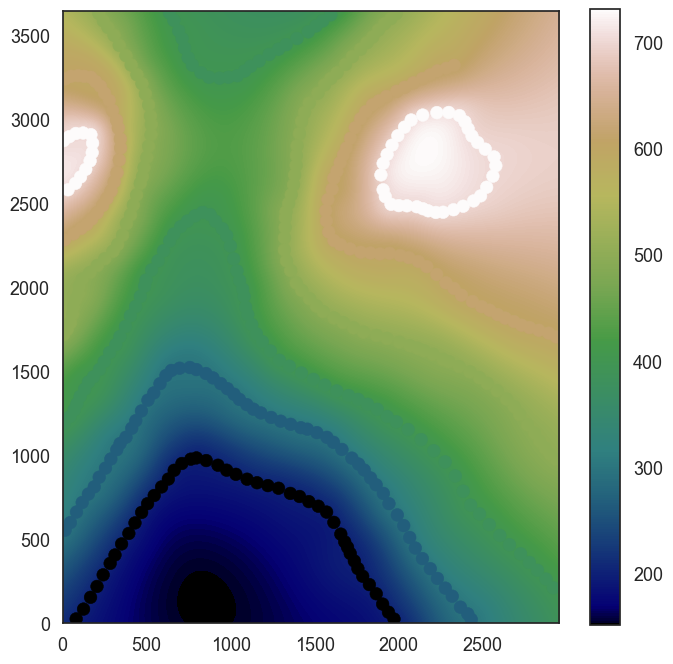

In [7]:
# Plot the DEM
fig, ax = plt.subplots(1, figsize=(8, 8))
topo.plot(ax=ax, aspect="equal", column="Z", cmap="gist_earth")
im = ax.imshow(topo_raster, origin="lower", extent=[0, 2950, 0, 3640], cmap="gist_earth")
cbar = plt.colorbar(im);

In [8]:
# Save the DEM as a tif file
gg.raster.save_as_tiff(raster=topo_raster, path="dem_map1.tif", 
                       extent=[0, 2950, 0, 3640], crs="EPSG:4326", overwrite_file=True)

Raster successfully saved


In [9]:
# Open the DEM from tif file
topo_raster = rasterio.open("dem_map1.tif")

## 2. Stratigraphic boundaries or units' contacts
The X and Y coordinates of points on the contacts between the units were also digitized into a text file. We only needed to digitize the X and Y values, as the Z values are extracted from the elevation model.

It is important to assign a unit name to each contact. In our case, the digitized contacts are the bases, i.e. the lower boundaries, of the units. 

In [10]:
# Read the points on the bedding contacts and display first five points
contacts = df_to_gdf(os.path.join("contacts", "contacts.txt"), sep="\t")
contacts.head()

,X,Y,formation,geometry
0,107.97,3588.58,T,POINT (107.97300 3588.57600)
1,772.45,3301.74,T,POINT (772.44700 3301.73700)
2,958.05,3279.39,T,POINT (958.05300 3279.39400)
3,1553.82,3466.96,T,POINT (1553.81900 3466.95800)
4,244.38,3517.25,T,POINT (244.38200 3517.24700)


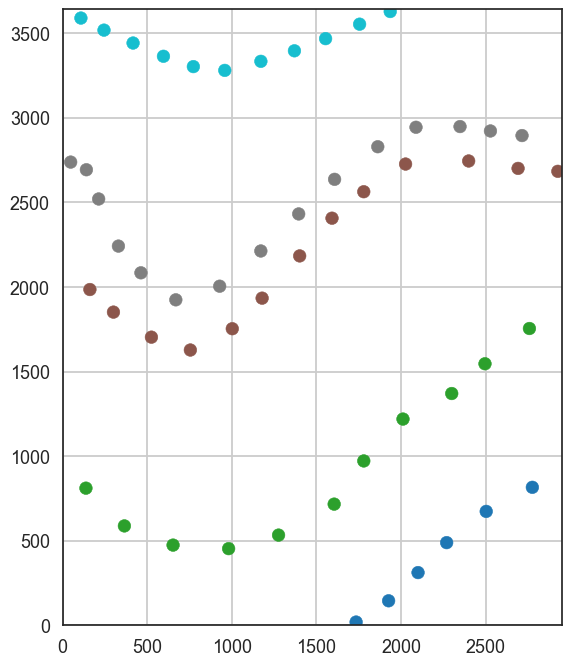

In [11]:
# Plot the points on the contacts in a map view
fig, ax = plt.subplots(1, figsize=(8, 8))
contacts.plot(ax=ax, column="formation", aspect="equal")
ax.set_ylim((0,3640))
ax.set_xlim((0,2950))
ax.grid();

### Extracting Z coordinate
The vertical coordinate (Z) of the points on the bedding contacts are extracted from the elevation model using the GemGIS function vector.extract_xyz()

In [12]:
# Extract the Z value of the points on the bedding contacts
contacts_with_Z = gg.vector.extract_xyz(gdf=contacts, dem=topo_raster)
contacts_with_Z.head()

,X,Y,formation,geometry,Z
0,107.97,3588.58,T,POINT (107.97300 3588.57600),534.87
1,772.45,3301.74,T,POINT (772.44700 3301.73700),401.89
2,958.05,3279.39,T,POINT (958.05300 3279.39400),398.34
3,1553.82,3466.96,T,POINT (1553.81900 3466.95800),432.94
4,244.38,3517.25,T,POINT (244.38200 3517.24700),514.61


### Strike Lines on base S
Strike lines connect points of equal elevation on a contact. They are basically horizontal lines on the contact. The dip is the maximum angle at which a planar feature (in our case a contact) is inclined with respect to the horizontal. GemGIS can calculate the dip and dip direction of a contact from two strike lines.

Let"s look at the base of unit S. We need two points of equal elevation on this contact to define a strike line.

In [13]:
# A text file with X, Y and Z coordinates. It contains the unit name and the id number. 
# The id number tells GemGIS which points are part of a strike line.
gdf_S = df_to_gdf(os.path.join("strike_lines", "strike_lines_S.txt"), sep="\t")
gdf_S.head()

,X,Y,Z,formation,id,geometry
0,1039.51,2092.03,400,S,1,POINT (1039.51400 2092.02800)
1,500.82,2037.59,400,S,1,POINT (500.82500 2037.58700)
2,326.79,2250.49,500,S,2,POINT (326.79400 2250.49100)
3,1323.05,2357.05,500,S,2,POINT (1323.04800 2357.04500)
4,249.05,2500.95,600,S,3,POINT (249.04900 2500.94900)


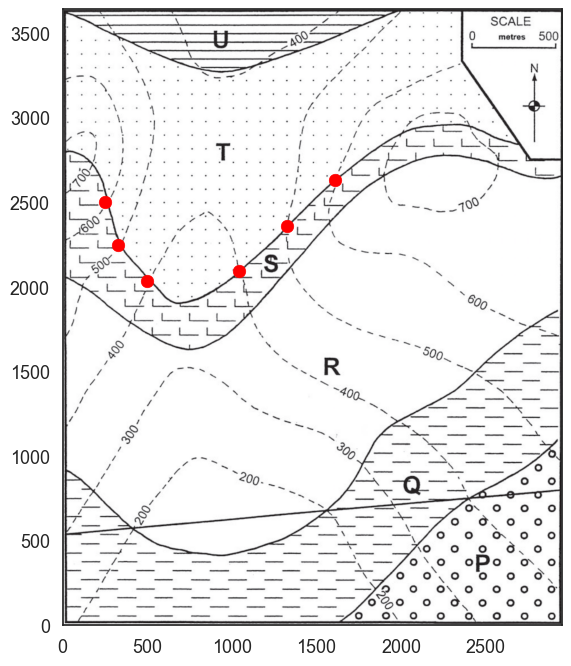

In [14]:
# Plot the points used to define the strike lines at the base of unit S
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img, extent=[0, 2950, 0, 3640], cmap="gray")
gdf_S.plot(ax=ax, aspect="equal", color="red");

In [15]:
# Now create line strings that represent the strike lines
linestring_gdf_S = gg.vector.create_linestring_gdf(gdf=gdf_S)
linestring_gdf_S.head()

,index,X,Y,Z,formation,id,geometry
0,0,1039.51,2092.03,400,S,1,"LINESTRING (1039.51400 2092.02800, 500.82500 2..."
1,2,326.79,2250.49,500,S,2,"LINESTRING (326.79400 2250.49100, 1323.04800 2..."
2,4,249.05,2500.95,600,S,3,"LINESTRING (249.04900 2500.94900, 1608.93500 2..."


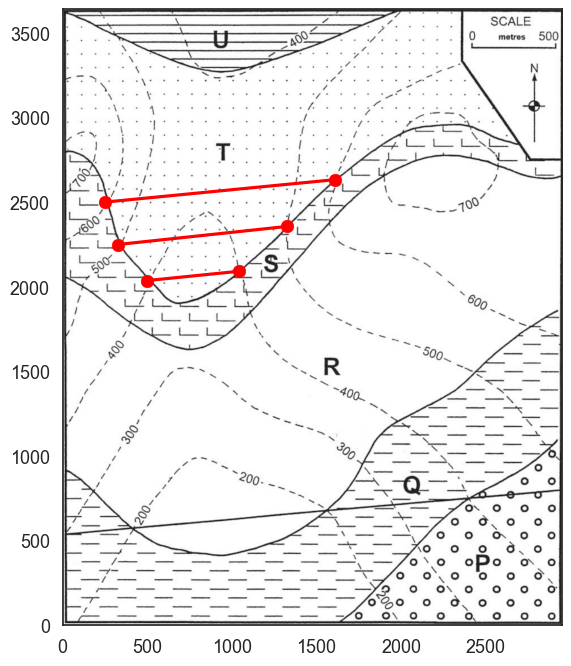

In [16]:
# Plot the strike lines. These are also the "Structural contours" on the base of S
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img, extent=[0, 2950, 0, 3640], cmap="gray")
gdf_S.plot(ax=ax, aspect="equal", color="red")
linestring_gdf_S.plot(ax=ax, aspect="equal", color="red");

### Orientation of base S from strike lines

The strike and dip of the contact (base of unit S) are calculated from two strike lines. The output is at the midpoint of each pair of strike lines, and this information can be used to construct the geological model in gempy.

In [17]:
# Check that the geometry of the strike line is valid
linestring_gdf_S.is_valid

0    True
1    True
2    True
dtype: bool

In [18]:
# Calculate the strike and dip of the base of unit S
orientations_S = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_S)
orientations_S.head()

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,23.48,173.97,450.00,POINT (797.54525 2184.28775),1.00,797.55,2184.29,S
1,22.00,174.24,550.00,POINT (876.95650 2435.53225),1.00,876.96,2435.53,S


The base of unit S dips 22-23 degrees to the south

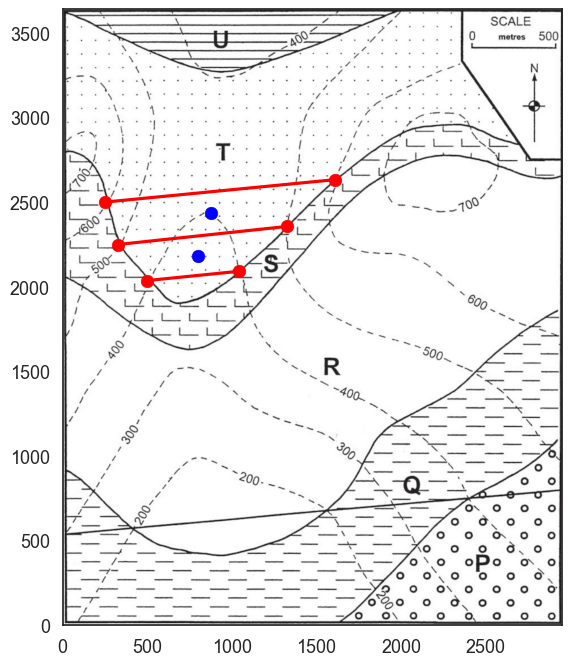

In [19]:
# Plot this information on the map, the blue dots are orientations
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img, extent=[0, 2950, 0, 3640], cmap="gray")
gdf_S.plot(ax=ax, aspect="equal", color="red")
linestring_gdf_S.plot(ax=ax, aspect="equal", color="red")
orientations_S.plot(ax=ax, aspect="equal", color="blue");

### Strike lines and orientation of base Q:

In [20]:
# Let"s do the same for the base of unit Q
gdf_Q = df_to_gdf(os.path.join("strike_lines", "strike_lines_Q.txt"), sep="\t")
linestring_gdf_Q = gg.vector.create_linestring_gdf(gdf=gdf_Q)
linestring_gdf_Q.head()

,index,X,Y,Z,formation,id,geometry
0,0,403.18,559.30,200,Q,1,"LINESTRING (403.17700 559.30400, 1554.97600 67..."
1,2,164.23,784.01,300,Q,2,"LINESTRING (164.22800 784.01200, 1765.24600 93..."


In [21]:
# Check that the geometry of the strike line is valid
linestring_gdf_Q.is_valid

0    True
1    True
dtype: bool

In [22]:
# Calculate the strike and dip of the base of unit Q
orientations_Q = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_Q)
orientations_Q.head()

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,22.06,174.45,250.00,POINT (971.90675 738.53150),1.00,971.91,738.53,Q


The base of unit Q dips similar to the base of unit S. This tells us that the units are "conformable", i.e. they have about the same orientation!

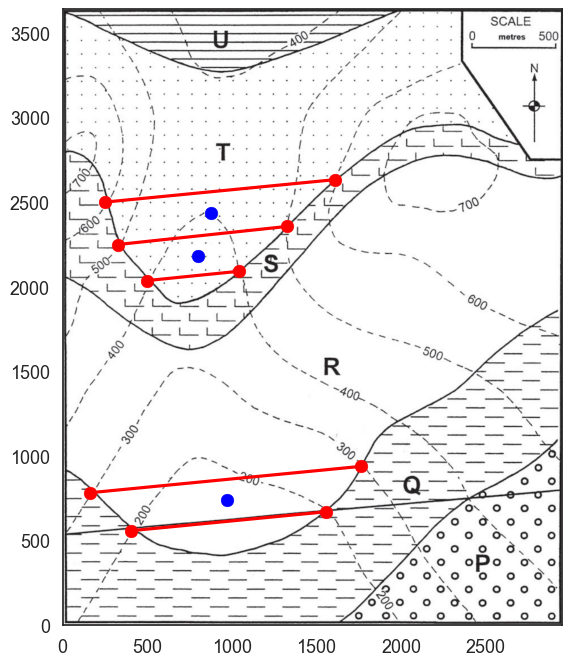

In [23]:
# Plot this information on the map, the blue dots are orientations
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img, extent=[0, 2950, 0, 3640], cmap="gray")
gdf_S.plot(ax=ax, aspect="equal", color="red")
linestring_gdf_S.plot(ax=ax, aspect="equal", color="red")
orientations_S.plot(ax=ax, aspect="equal", color="blue")
gdf_Q.plot(ax=ax, aspect="equal", color="red")
linestring_gdf_Q.plot(ax=ax, aspect="equal", color="red")
orientations_Q.plot(ax=ax, aspect="equal", color="blue");

### Merge and plot the  calculated orientations

In [24]:
# Merge the calculated orientations
orientations = pd.concat([orientations_Q,orientations_S]).reset_index()
orientations.head()

,index,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,0,22.06,174.45,250.00,POINT (971.90675 738.53150),1.00,971.91,738.53,Q
1,0,23.48,173.97,450.00,POINT (797.54525 2184.28775),1.00,797.55,2184.29,S
2,1,22.00,174.24,550.00,POINT (876.95650 2435.53225),1.00,876.96,2435.53,S


## 3. Construction of the model in GemPy

In [25]:
# Create a geomodel object called model1
geo_model = gp.create_model("model1")

In [26]:
# Define model extent, resolution, surface points, and orientations
# This command creates a regular grid with the extent and resolution given by:

# Extent: [x_min, x_max, y_min, y_max, z_min, z_max]
# Resolution: [nx, ny, nz]
gp.init_data(geo_model, [0, 2950, 0, 3640, 0, 1000], [100, 100, 100],
             surface_points_df=contacts_with_Z,
             orientations_df=orientations, default_values=True);

Active grids: ['regular']


In [27]:
# Check default series
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,T,Default series,1,#015482,1
1,S,Default series,2,#9f0052,2
2,R,Default series,3,#ffbe00,3
3,Q,Default series,4,#728f02,4
4,P,Default series,5,#443988,5


In the "series" column above, we can see that the surfaces belong to the default series. Since the units are conformable, we assign them below to one series called Strata.

In [28]:
# The base of the lowermost unit U does not outcrop in the map
# This unit is our "basement", we add it manually
geo_model.add_surfaces("U")

# Group all the surfaces as a series called Strata
gp.map_stack_to_surfaces(geo_model, {"Strata": ("P","Q","R","S","T","U"),},
                         remove_unused_series=True)


,surface,series,order_surfaces,color,id
0,T,Strata,1,#015482,1
1,S,Strata,2,#9f0052,2
2,R,Strata,3,#ffbe00,3
3,Q,Strata,4,#728f02,4
4,P,Strata,5,#443988,5
5,U,Strata,6,#ff3f20,6


In [29]:
# Check that the data are correct
gg.utils.show_number_of_data_points(geo_model=geo_model)

,surface,series,order_surfaces,isBasement,isFault,isActive,hasData,color,vertices,edges,sfai,id,No. of Interfaces,No. of Orientations
0,T,Strata,1,False,False,True,True,#015482,NaN,NaN,NaN,1,11,0
1,S,Strata,2,False,False,True,True,#9f0052,NaN,NaN,NaN,2,15,2
2,R,Strata,3,False,False,True,True,#ffbe00,NaN,NaN,NaN,3,13,0
3,Q,Strata,4,False,False,True,True,#728f02,NaN,NaN,NaN,4,11,1
4,P,Strata,5,False,False,True,True,#443988,NaN,NaN,NaN,5,6,0
5,U,Strata,6,True,False,True,True,#ff3f20,NaN,NaN,NaN,6,0,0


In [30]:
# Add the topography (DEM) to the geomodel
geo_model.set_topography(source="gdal", filepath="dem_map1.tif");

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


In [31]:
# Plot the points on the contacts and topography in 3D 
# This will open a PyVista window. This may take some time, please wait
gp.plot_3d(geo_model, plotter_type="background",show_topography=True);

In [32]:
# Now we have enough data to interpolate. This may take some time, please wait
gp.set_interpolator(geo_model, compile_theano=True,
                    theano_optimizer="fast_compile");

Setting kriging parameters to their default values.
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                    values
range             4790.84
$C_o$           546478.57
drift equations       [3]


In [33]:
# Compute the geological model. This may take some time, please wait
gp.compute_model(geo_model);

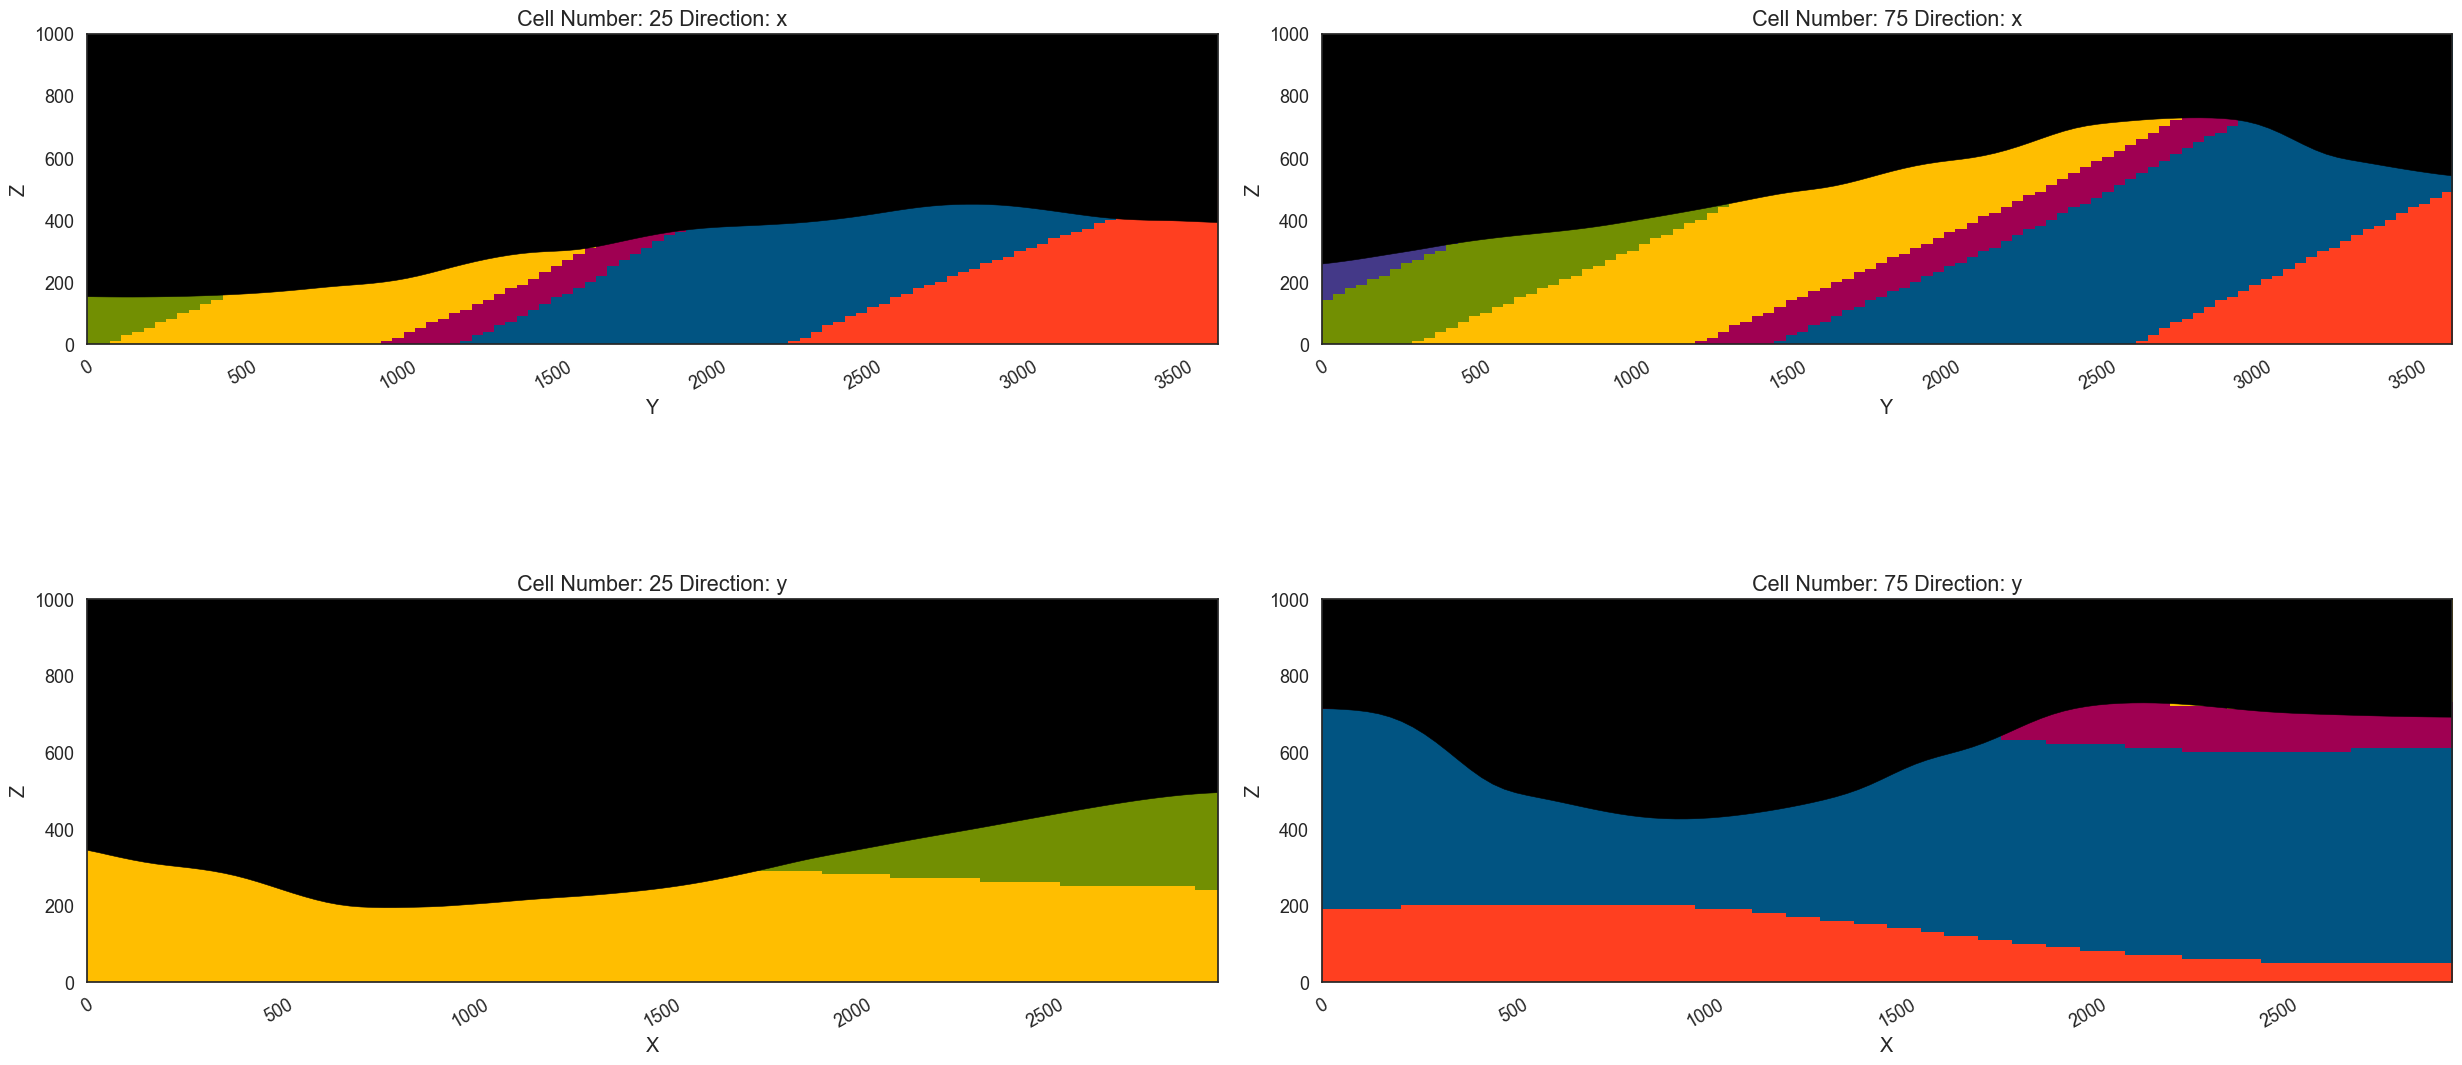

In [34]:
# Plot north-south and east-west sections without vertical exaggeration
gp.plot_2d(geo_model, direction=["x", "x", "y", "y"], cell_number=[25, 75, 25, 75], 
           show_data=False, show_boundaries=False, show_topography=True, show=False);

In [35]:
# Plot the geomodel in 3D, this will open a PyVista window. This may take some time, please wait
gp.plot_3d(geo_model, plotter_type="background", show_topography=True, show_lith=False);

Though the contacts are essentially planar and conformable, we can see that they have some small undulations. These can be due to few control points and errors in the coordinates of the points (the units are not fully conformable).